In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns

In [4]:
import janitor as jn
import yellowbrick.features as ybf
import yellowbrick.model_selection as ybm
import yellowbrick.classifier as ybc
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import *
from sklearn.model_selection import *
from sklearn.preprocessing import *
from sklearn.ensemble import *

In [3]:
df = pd.read_csv('../data/titanic_train.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [7]:
def tweak_titanic(df):
    df = (
        df.drop(columns=["Name", "Ticket", "Cabin"])
            .pipe(pd.get_dummies, drop_first=True)
    )
    return df

def get_train_test_X_y(df, target, size=0.3, std_cols=None):
    X, y = df.get_features_targets(target_columns=target)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=size, random_state=42)
    cols = X.columns
    num_cols = ["Pclass", "Age", "SibSp", "Parch", "Fare"]
    
    imp = IterativeImputer()
    fitted = imp.fit_transform(X_train[num_cols])
    
    X_train = X_train.assign(**{c:fitted[:,i] for i, c in enumerate(num_cols)})
    test_fit = imp.transform(X_test[num_cols])
    X_test = X_test.assign(**{c:test_fit[:,i] for i, c in enumerate(num_cols)})
    
    if std_cols:
        std = StandardScaler()
        fitted = std.fit_transform(X_train[std_cols])
        X_train = X_train.assign(**{c:fitted[:,i] for i, c in enumerate(std_cols)})
        test_fit = std.transform(X_test[std_cols])
        X_test = X_test.assign(**{c:test_fit[:,i] for i, c in enumerate(std_cols)})

    return X_train, X_test, y_train, y_test

ti_df = tweak_titanic(df)
std_cols = "Pclass,Age,SibSp,Fare".split(",")

target = "Survived"

X_train, X_test, y_train, y_test = get_train_test_X_y(ti_df, target, std_cols=std_cols)

X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])

## Confusion Matrix

In [14]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import *

In [8]:
dt = DecisionTreeClassifier(random_state=42, max_depth=3)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=42)

In [9]:
y_predict = dt.predict(X_test)
tp = ((y_test == 1) & (y_test == y_predict)).sum()  # 123
tn = ((y_test == 0) & (y_test == y_predict)).sum()  # 199
fp = ((y_test == 0) & (y_test != y_predict)).sum()  # 25
fn = ((y_test == 1) & (y_test != y_predict)).sum()  # 46

In [11]:
y_predict = dt.predict(X_test)
pd.DataFrame(
    confusion_matrix(y_test, y_predict),
    columns=["Predict died", "Predict Survive"],
    index=["True Death", "True Survive"]
)

,Predict died,Predict Survive
True Death,141,16
True Survive,33,78


C:\Scoop\apps\miniconda-cn\current\envs\kaggle\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
C:\Scoop\apps\miniconda-cn\current\envs\kaggle\lib\site-packages\yellowbrick\classifier\base.py:230: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


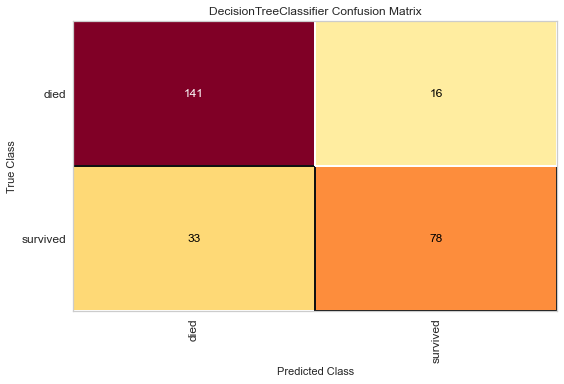

<AxesSubplot:title={'center':'DecisionTreeClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [12]:
mapping = {0: "died", 1: "survived"}

cm_viz = ybc.ConfusionMatrix(
    dt,
    classes=["died", "survived"],
    label_encoder=mapping,
)

cm_viz.score(X_test, y_test)
cm_viz.poof()

In [15]:
y_predict = dt.predict(X_test)
accuracy_score(y_test, y_predict)

0.8171641791044776

In [17]:
recall_score(y_test, y_predict)

0.7027027027027027

In [18]:
precision_score(y_test, y_predict)

0.8297872340425532

In [19]:
f1_score(y_test, y_predict)

0.7609756097560975

## Classication Report

C:\Scoop\apps\miniconda-cn\current\envs\kaggle\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
C:\Scoop\apps\miniconda-cn\current\envs\kaggle\lib\site-packages\yellowbrick\classifier\base.py:230: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


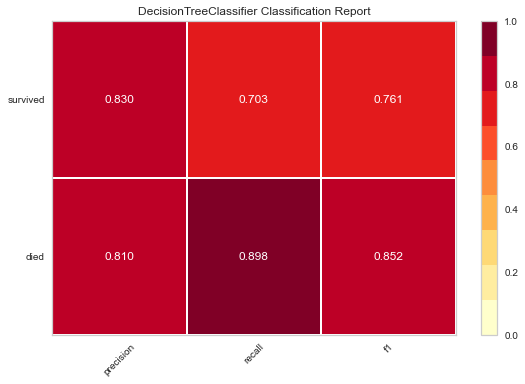

<AxesSubplot:title={'center':'DecisionTreeClassifier Classification Report'}>

In [20]:
cm_viz = ybc.ClassificationReport(
    dt,
    classes=["died", "survived"],
    label_encoder=mapping,
)

cm_viz.score(X_test, y_test)
cm_viz.poof()

## ROC

In [21]:
y_predict = dt.predict(X_test)
roc_auc_score(y_test, y_predict)

0.8003959373386125

AttributeError: 'DecisionTreeClassifier' object has no attribute 'target_type_'

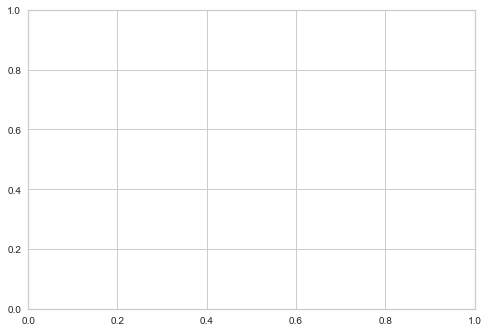

In [36]:
roc_viz = ybc.ROCAUC(dt)
roc_viz.score(X_test, y_test)
roc_viz.poof()

## Precision-Recall Curve

In [25]:
y_predict = dt.predict(X_test)
average_precision_score(y_test, y_predict)

0.7062280603881111

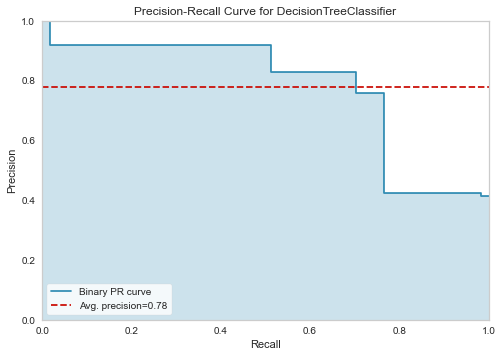

<AxesSubplot:title={'center':'Precision-Recall Curve for DecisionTreeClassifier'}, xlabel='Recall', ylabel='Precision'>

In [35]:
viz = ybc.PrecisionRecallCurve(DecisionTreeClassifier(max_depth=3))
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
viz.poof()

## Class Balance

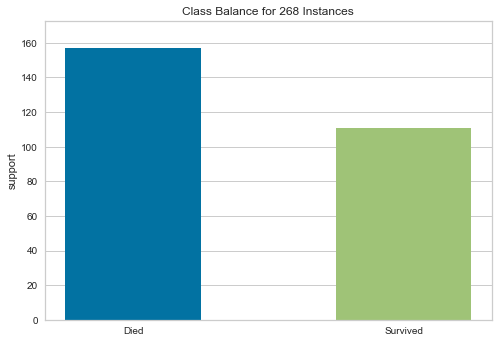

<AxesSubplot:title={'center':'Class Balance for 268 Instances'}, ylabel='support'>

In [29]:
cb_viz = ybc.ClassBalance(labels=["Died", "Survived"])
cb_viz.fit(y_test)
cb_viz.poof()

## Class Prediction Error

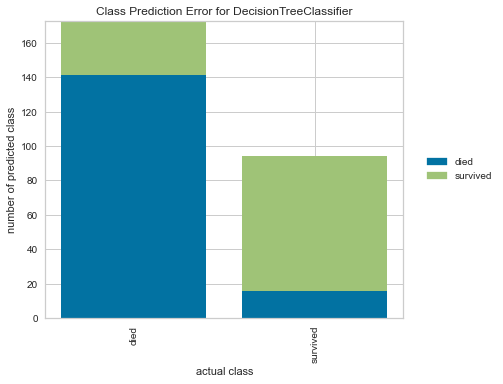

<AxesSubplot:title={'center':'Class Prediction Error for DecisionTreeClassifier'}, xlabel='actual class', ylabel='number of predicted class'>

In [34]:
cpe_viz = ybc.ClassPredictionError(dt, classes=["died", "survived"])
cpe_viz.score(X_test, y_test)
cpe_viz.poof()

## Discrimination Threshold

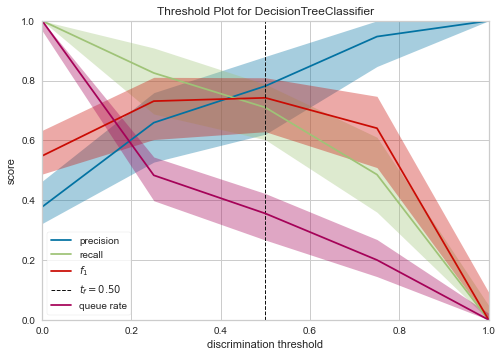

<AxesSubplot:title={'center':'Threshold Plot for DecisionTreeClassifier'}, xlabel='discrimination threshold', ylabel='score'>

In [33]:
dt_viz = ybc.DiscriminationThreshold(dt)
dt_viz.fit(X, y)
dt_viz.poof()

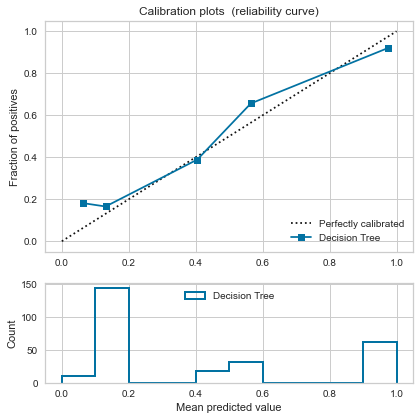

In [37]:
from sklearn.calibration import calibration_curve

def calib_plot(clf, name, X_test):
    fig = plt.figure(figsize=(6, 6))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))
    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    clf.fit(X_train, y_train)
    if hasattr(clf, "predict_proba"):
        prob_pos = clf.predict_proba(X_test)[:, 1]
    else:  # use decision function
        prob_pos = clf.decision_function(X_test)
        prob_pos = (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())
    fraction_of_positives, mean_predicted_value = calibration_curve(
        y_test, prob_pos, n_bins=10
    )
    ax1.plot(
        mean_predicted_value,
        fraction_of_positives,
        "s-",
        label=f"{name}",
    )
    ax2.hist(
        prob_pos,
        range=(0, 1),
        bins=10,
        label=name,
        histtype="step",
        lw=2,
    )
    ax1.set_ylabel("Fraction of positives")
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc="lower right")
    ax1.set_title("Calibration plots  (reliability curve)")
    ax2.set_xlabel("Mean predicted value")
    ax2.set_ylabel("Count")
    ax2.legend(loc="upper center", ncol=2)
    plt.tight_layout()
    plt.show()
    return fig

fig = calib_plot(dt, "Decision Tree", X_test)

## Shapley

In [39]:
rf5 = RandomForestClassifier(
    **{
        "max_features": "auto",
        "min_samples_leaf": 0.1,
        "n_estimators": 200,
        "random_state": 42,
    }
)
rf5.fit(X_train, y_train)

RandomForestClassifier(min_samples_leaf=0.1, n_estimators=200, random_state=42)

In [40]:
import shap

shap.initjs()
s = shap.TreeExplainer(rf5)
shap_vals = s.shap_values(X_test)
target_idx = 1

shap.force_plot(
    s.expected_value[target_idx],
    shap_vals[target_idx][20, :],
    feature_names=X_test.columns,
)

In [41]:
shap.force_plot(
    s.expected_value[1],
    shap_vals[1],
    feature_names=X_test.columns,
)

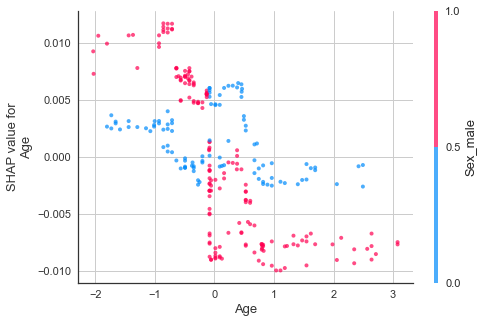

In [43]:
res = shap.dependence_plot(
    "Age",
    shap_vals[target_idx],
    X_test,
    feature_names=X_test.columns,
    alpha=0.7,
)

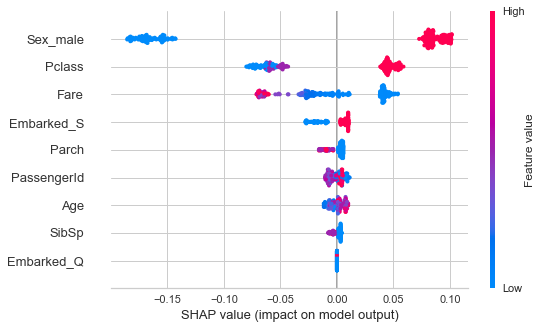

In [44]:
shap.summary_plot(shap_vals[0], X_test)